# Minimize Monetary Cost 
**Team Member:** **Yucheol-Shin**, **Ricco Ferraro**

# Business Understanding

Given a large data set without a clear data description, the task in this study is to classify 0 and 1 for a target variable. There is a set monetary loss for incorrect prediction. As such, our goal is compare models capable of predicting class 1 or class 0, where the penalty for incrorrectly predicting 1 is \\$100.00 per prediction, and the penalty for incorrectly   predicting class 0 is \\$25.00 per prediction. Note: the penalty for correclty predicting class 0 or class 1 is none or \\$0.00. The goal of this study is to compare models which minimize the monetary loss of the our client.

# Data Engineering

In [138]:
# imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import glob, os 
import joblib
import warnings

from os import listdir
from os.path import isfile, join
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.ensemble import VotingClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [3]:
# helper functions
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            print("Transformer %s (type %s) does not "
                  "provide get_feature_names. "
                  "Will return input column names if available"
                  % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

# Helper Function to perform One Hot Encoder
def one_hot_encode_data(data):
    cat_cols = []
    for col in data.columns:
        if data[col].dtype == object:
            cat_cols.append(col)
            
    encoder = OneHotEncoder(handle_unknown='ignore')
    codes = encoder.fit_transform(data[cat_cols])
    encoded_data = pd.DataFrame(codes.todense(), columns=encoder.get_feature_names(cat_cols), index=data.index).sort_index()

    return encoded_data

In [315]:
print(Path.cwd()/"final_project(5).csv")
df = pd.read_csv(Path.cwd()/"final_project(5).csv")
df.head()

/Users/riccoferraro/Documents/SMU/QTW/QTW/final_project(5).csv


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,6.187465,13.251523,25.665413,-5.017267,10.503714,-2.517678,2.117910,5.865923,-6.666158,1.791497,-1.909114,-1.737940,-2.516715,3.553013,euorpe,-0.801340,1.142950,1.005131,-18.473784,July,tuesday,-3.851669,0.0%,-1.940031,-5.492063,0.627121,-0.873824,$1313.96,-1.353729,-5.186148,-10.612200,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,-11.708859,-2.352809,-25.014934,9.799608,-10.960705,1.504000,-2.397836,-9.301839,-1.999413,5.045258,-5.809984,10.814319,-0.478112,10.590601,asia,0.818792,-0.642987,0.751086,3.749377,Aug,wednesday,1.391594,-0.02%,2.211462,-4.460591,1.035461,0.228270,$1962.78,32.816804,-5.150012,2.147427,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,1.572647,-4.170771,12.078602,-5.158498,7.302780,-2.192431,-4.065428,-7.675055,4.041629,-6.633628,1.700321,-2.419221,2.467521,-5.270615,asia,-0.718315,-0.566757,4.171088,11.522448,July,wednesday,-3.262082,-0.01%,0.419607,-3.804056,-0.763357,-1.612561,$430.47,-0.333199,8.728585,-0.863137,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,-2.000255,-19.286668,10.995330,-5.914378,2.511400,1.292362,-2.496882,-15.722954,-2.735382,1.117536,1.923670,-14.179167,1.470625,-11.484431,asia,-0.052430,-0.558582,9.215569,30.595226,July,wednesday,-2.285241,0.01%,-3.442715,4.420160,1.164532,3.033455,$-2366.29,14.188669,-6.385060,12.084421,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,6.667530,1.965913,-28.106348,-1.258950,5.759941,0.472584,-1.150097,-14.118709,4.527964,-1.284372,-9.026317,-7.039818,-1.978748,-15.998166,asia,-0.223449,0.350781,1.811182,-4.094084,July,tuesday,0.921047,0.01%,-0.431640,12.165494,-0.167726,-0.341604,$-620.66,-12.578926,1.133798,30.004727,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


As can be seen, the data includes 50 explanatory variables labeled `x0-x49` and a single target variable `y`. The data is not already scaled equally. 

In [7]:
df.describe(include = "all")

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000,159957.000000,159970.000000,159964.000000,159969.000000,159966.000000,159965.000000,159974.000000,159973.000000,159960.000000,159965.000000,159962.000000,159971.000000,159973.000000,159953.000000,159972,159978.000000,159964.000000,159970.000000,159965.000000,159970,159970,159961.000000,159969,159959.000000,159959.000000,159970.000000,159973.000000,159977,159969.000000,159977.000000,159964.000000,159960.000000,159974.000000,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000,160000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,12,5,NaN,12,NaN,NaN,NaN,NaN,129198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,asia,NaN,NaN,NaN,NaN,July,wednesday,NaN,0.01%,NaN,NaN,NaN,NaN,$-311.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138965,NaN,NaN,NaN,NaN,45569,101535,NaN,40767,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549,0.013582,-1.670670,-7.692795,-0.030540,0.005462,0.002253,0.030232,-1.334402,0.007669,0.008104,0.001215,0.006223,0.012040,0.012694,0.024555,0.299074,-0.029137,0.008400,0.722028,NaN,-0.000806,-0.001066,-0.004159,0.031543,NaN,NaN,-0.005945,NaN,-0.006567,-0.000426,0.000936,0.006453,NaN,6.059130,0.004253,-2.316526,6.701076,-1.833820,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224,0.401231
std,0.371137,6.340632,13.273480,8.065032,6.382293,7.670076,19.298665,30.542264,8.901185,6.355040,7.871429,8.769633,14.750990,8.953837,6.964097,3.271779,4.984065,7.569351,4.540714,7.595316,5.806203,9.409635,5.412010,14.909127,NaN,1.263656,0.843258,6.774047,14.439534,NaN,NaN,2.767508,NaN,1.747762,8.014180,2.379558,1.593183,NaN,16.891603,5.134322,17.043549,18.680196,5.110705,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738,0.490149
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659,-36.306571,-38.092869,-64.197967,-38.723514,-30.905214,-17.002359,-26.042983,-34.395898,-20.198686,-35.633396,-26.677396,-43.501854,-23.644193,-66.640341,NaN,-6.364653,-3.857484,-32.003555,-72.896705,NaN,NaN,-12.289364,NaN,-7.451454,-36.116606,-10.008149,-6.866024,NaN,-74.297559,-22.101647,-74.059196,-82.167224,-27.933750,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191,0.000000
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619,-5.288196,-5.903274,-11.379492,-6.029945,-4.696755,-2.207774,-3.344027,-5.071470,-3.056131,-5.101553,-3.607789,-6.361115,-3.649766,-9.268532,NaN,-0.852784,-0.567293,-4.597919,-9.702464,NaN,NaN,-1.874206,NaN,-1.183681,-5.401084,-1.610337,-1.068337,NaN,-5.249882,-3.458716,-13.953629,-5.804080,-5.162869,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753,0.000000
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857,0.014118,-1.948594,-6.956789,-0.016840,0.006045,-0.018176,0.010941,-1.624439,-0.003473,0.002467,0.003535,0.012754,0.024541,0.015904,0.044703,0.433055,-0.026385,0.011144,1.029609,NaN,-0.003723,-0.001501,0.037138,0.244210,NaN,NaN,0.002013,NaN,-0.006079,-0.013089,-0.002399,0.003645,NaN,6.184410,0.019068,-2.701867,6.840110,-1.923754,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410,0.000000
75%,0.248532,4.284220,7.871676,5.445179,4.306660,5.190749,11.446931,12.217071,5.972349,4.3

Note: There are 160000 total records. 

In [8]:
df.shape

(160000, 51)

When examining the datatypes we can see that most of the data is numerical, but the target variable `y` is categorical, and there are several explanatory variables which are categorical. 

In [9]:
df.dtypes

x0     float64
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
x18    float64
x19    float64
x20    float64
x21    float64
x22    float64
x23    float64
x24     object
x25    float64
x26    float64
x27    float64
x28    float64
x29     object
x30     object
x31    float64
x32     object
x33    float64
x34    float64
x35    float64
x36    float64
x37     object
x38    float64
x39    float64
x40    float64
x41    float64
x42    float64
x43    float64
x44    float64
x45    float64
x46    float64
x47    float64
x48    float64
x49    float64
y        int64
dtype: object

### Data conversation to Numeric

Column `x37` is financial amount and it is marked as the type `object`. Since it is a dollar amount which is numeric, we need to convert it to numeric variable. 

Note for column `x32`, it appears to be numeric however there are only 12 unique levels. Thus we treat it as a categorical variable.

In [10]:
df[df.columns[df.dtypes == 'object']].head(10)

,x24,x29,x30,x32,x37
0,euorpe,July,tuesday,0.0%,$1313.96
1,asia,Aug,wednesday,-0.02%,$1962.78
2,asia,July,wednesday,-0.01%,$430.47
3,asia,July,wednesday,0.01%,$-2366.29
4,asia,July,tuesday,0.01%,$-620.66
5,asia,Aug,wednesday,-0.01%,$-196.45
6,asia,Jun,wednesday,-0.01%,$-241.04
7,asia,Aug,wednesday,0.01%,$621.35
8,asia,May,wednesday,-0.03%,$-301.89
9,asia,Jun,wednesday,0.01%,$-484.09


In [169]:
df['x37'].replace({'\$':''}, regex = True, inplace=True)
df["x37"] = pd.to_numeric(df["x37"])

In [316]:
df['x32'].nunique()

12

### Missing Values

As can be seen, there are missing data rows for nearly every explanatory variable.

In [13]:
df[df.columns[df.dtypes == 'float64']].isnull().sum()

x0     26
x1     25
x2     38
x3     37
x4     26
x5     37
x6     26
x7     27
x8     21
x9     30
x10    43
x11    30
x12    36
x13    31
x14    34
x15    35
x16    26
x17    27
x18    40
x19    35
x20    38
x21    29
x22    27
x23    47
x25    22
x26    36
x27    30
x28    35
x31    39
x33    41
x34    41
x35    30
x36    27
x37    23
x38    31
x39    23
x40    36
x41    40
x42    26
x43    37
x44    40
x45    29
x46    31
x47    37
x48    32
x49    32
dtype: int64

In [14]:
df[df.columns[df.dtypes == 'object']].isnull().sum()

x24    28
x29    30
x30    30
x32    31
dtype: int64

In a 'worst case' scenario where missing values for different explanatory variables occur exclusively in different rows, the total number of missing values is 1489.

In [15]:
df[df.columns[df.dtypes == 'float64']].isnull().sum().sum()

1489

In [16]:
df[df.columns[df.dtypes == 'object']].isnull().sum().sum()

119

After removing every row with missing data, we can see that only `1.005%` has been removed. As this is small minority of our data, we choose to simply drop every missing data row. 

**Note: this requires the assumption that any future analysis or prediction requires all features and is non empty for all columns.**

In [17]:
print(f"percentage of missing data is {100 - len(df.dropna()) / len(df) * 100}%")

percentage of missing data is 1.0049999999999955%


In [18]:
df = df.dropna()

In [19]:
df[df.columns].isnull().sum().sum()

0

## EDA

### Target variable Distribution

As can be seen below, the target variable is somewhat balanced. There is a slight skew towards the null class of `0`. 

<AxesSubplot:xlabel='y', ylabel='count'>

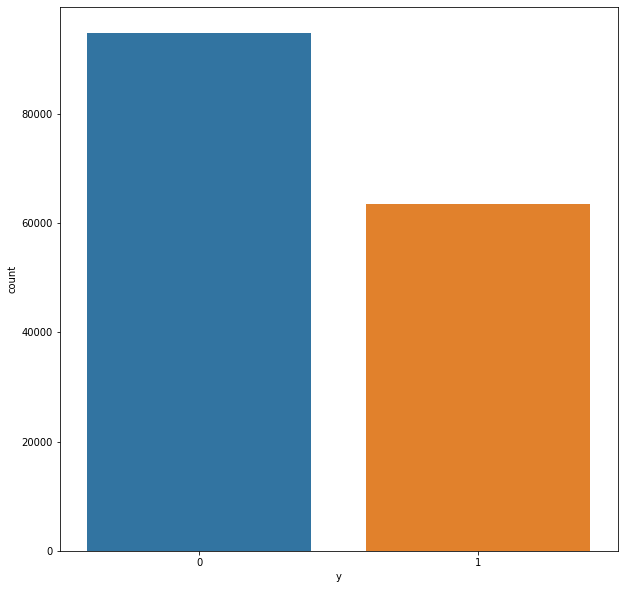

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.countplot(data=df, x='y', ax=ax)

### Distribution of Features
As can be seen in the distribution plots, most explanatory variables are normally distributed for both the target variable y value of 1 and y value of 0.

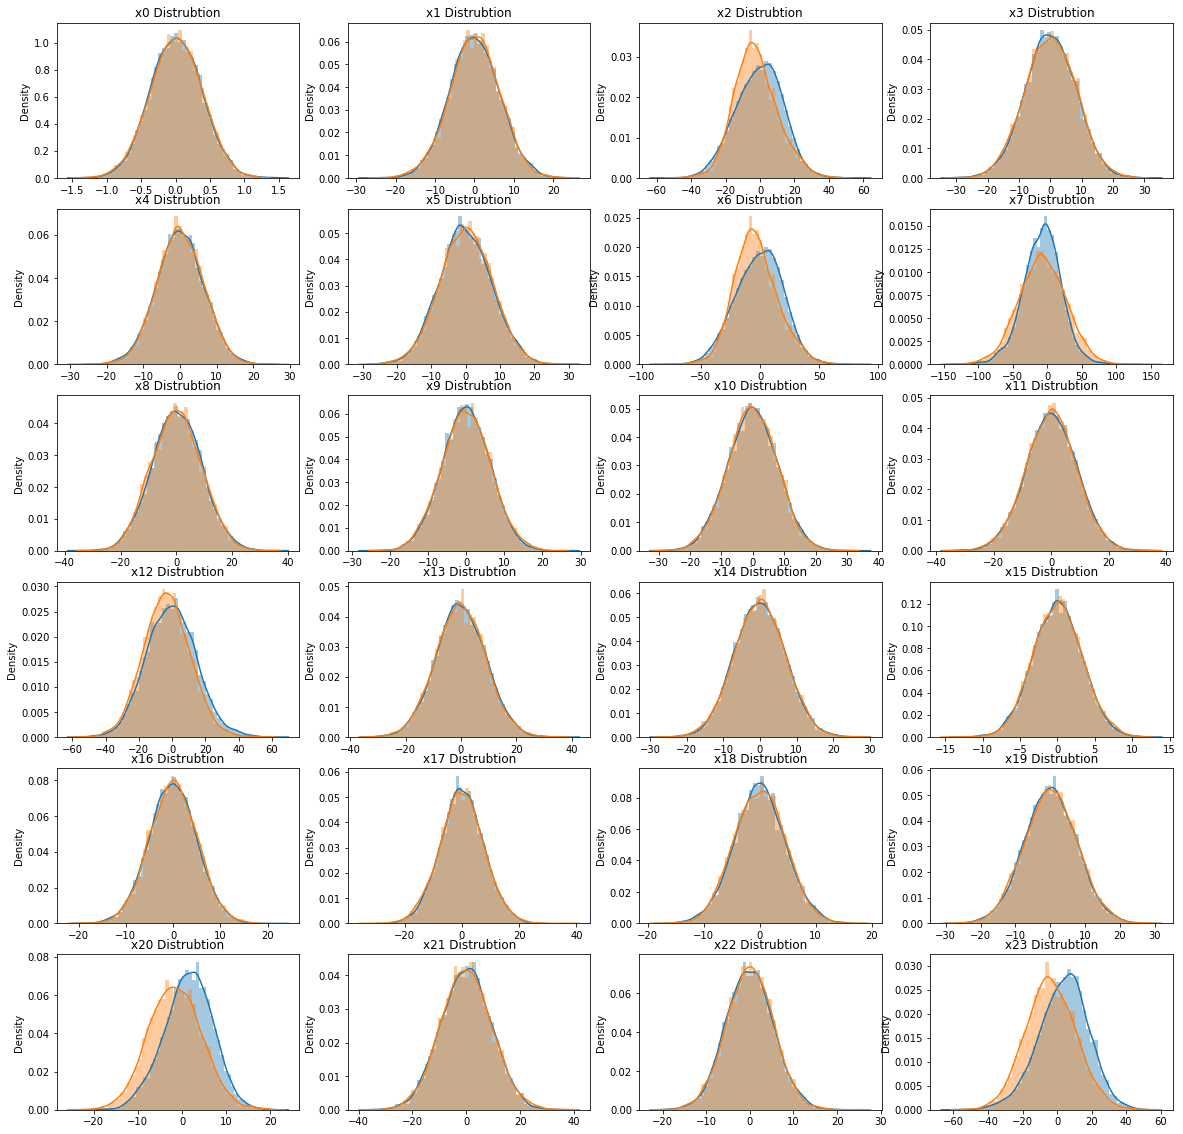

In [21]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20,20))

df_sample = df.sample(frac=0.1, replace=False, random_state=1)
df_sample_0 = df_sample[df_sample['y'] == 0]
df_sample_1 = df_sample[df_sample['y'] == 1]
for i, column in enumerate(df.columns[0:24]):
    row = int(i / 4)
    col = i % 4
    ax = axes[row, col]
    sns.distplot(x=df_sample_0[column], ax=ax)
    ax.set_title(f"{column} Distrubtion")
    
    sns.distplot(x=df_sample_1[column], ax=ax)
    ax.set_title(f"{column} Distrubtion")

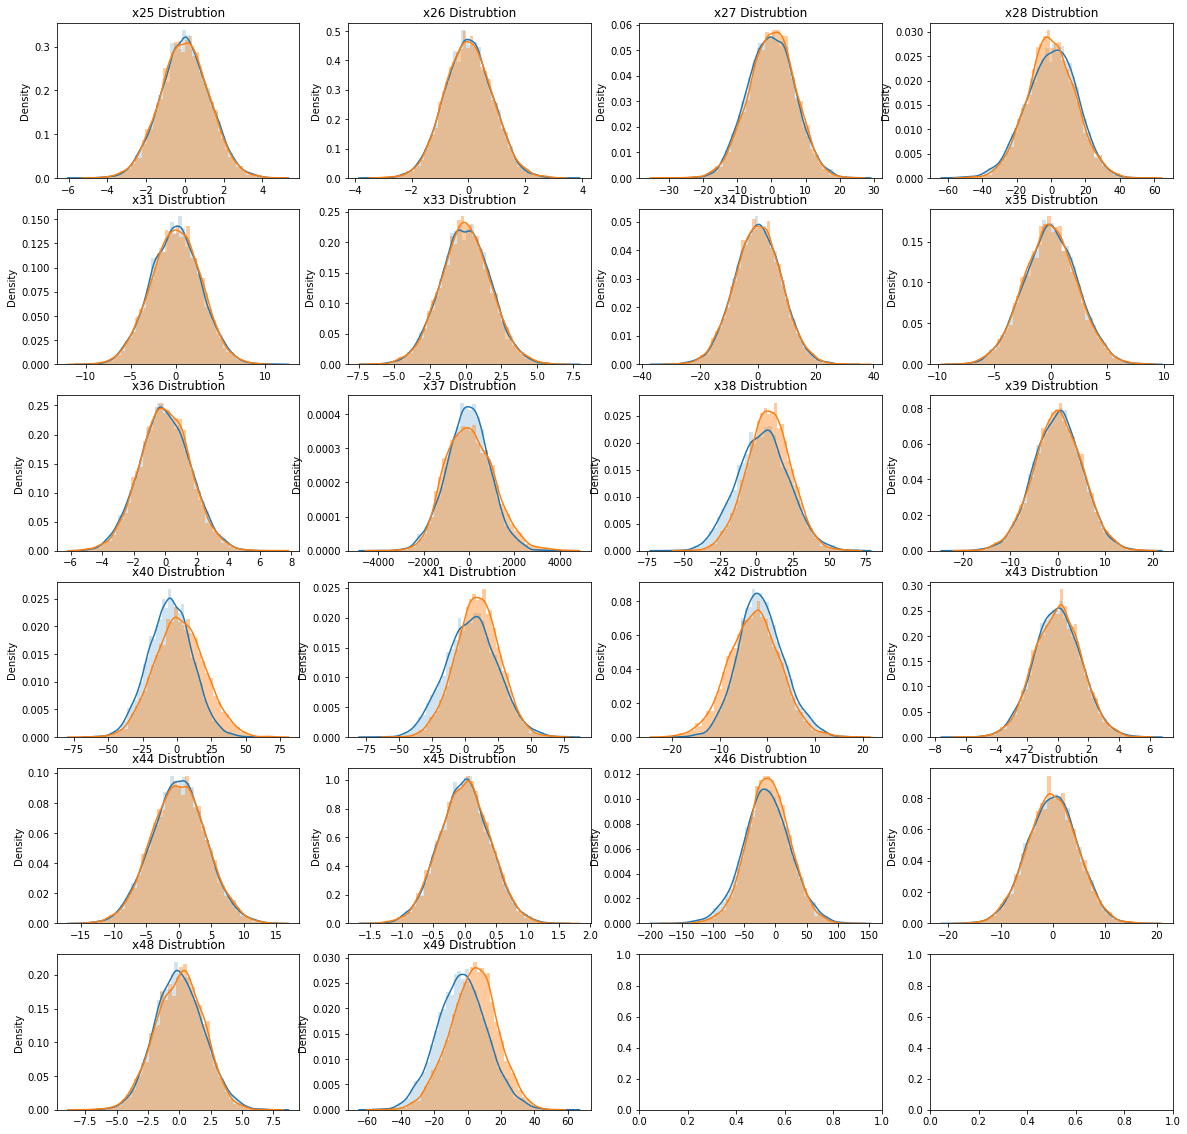

In [22]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20,20))

for i, column in enumerate(df.columns[df.dtypes != 'object'][24:-1]):
    row = int(i / 4)
    col = i % 4
    ax = axes[row, col]
    sns.distplot(x=df_sample_0[column], ax=ax, hist_kws=dict(alpha=0.2))
    ax.set_title(f"{column} Distrubtion")
    
    sns.distplot(x=df_sample_1[column], ax=ax)
    ax.set_title(f"{column} Distrubtion")

### Count Plot of Categorical Variables

As you can see in the raw count plots, the categorical features of country are imbalanced. Asia has more records than the other regions. This is likely a simple reflection of the population difference between regions.

Text(0.5, 1.0, 'x24 Distrubtion')

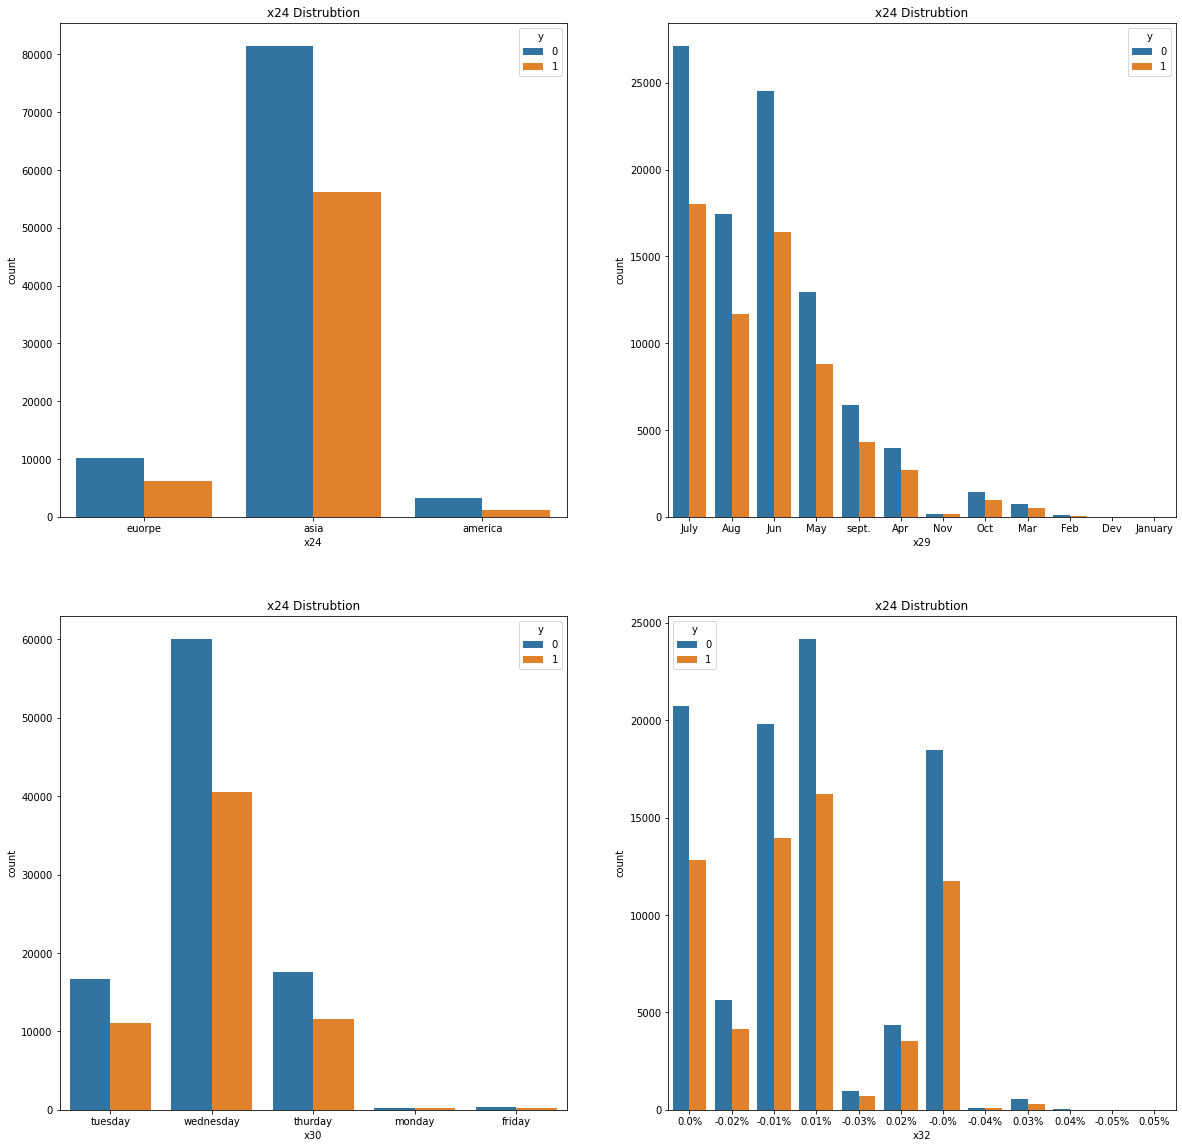

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

ax = axs[0,0]
sns.countplot(x=df['x24'], ax=ax, hue=df['y'])
ax.set_title("x24 Distrubtion")

ax = axs[0,1]
sns.countplot(x=df['x29'], ax=ax, hue=df['y'])
ax.set_title("x24 Distrubtion")

ax = axs[1,0]
sns.countplot(x=df['x30'], ax=ax, hue=df['y'])
ax.set_title("x24 Distrubtion")

ax = axs[1,1]
sns.countplot(x=df['x32'], ax=ax, hue=df['y'])
ax.set_title("x24 Distrubtion")

### Distribution of Categorical Variables by Percentage

##### X24 vs Y
As can be seen, the region `America` has relatively higher percentage of the target variable of y being 0.

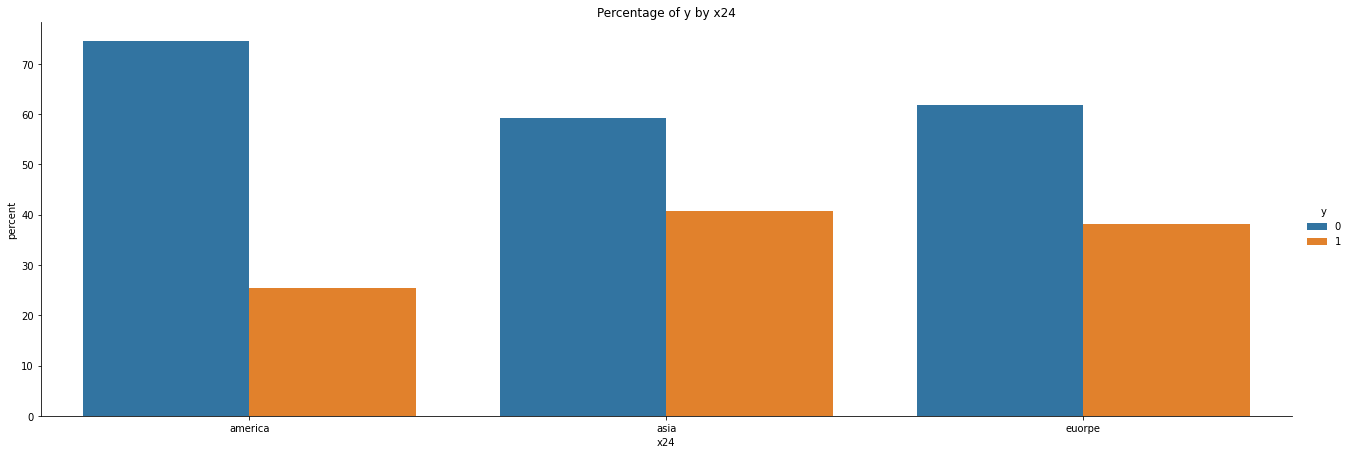

In [24]:
(df
.groupby('x24')['y']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='x24',y='percent',hue='y', kind='bar', height=6, aspect=3))
plt.title("Percentage of y by x24") ;

##### X29 vs Y

the categorical variable of `x29` which is likely ‘month’ shows that there is some seasonal behavior.

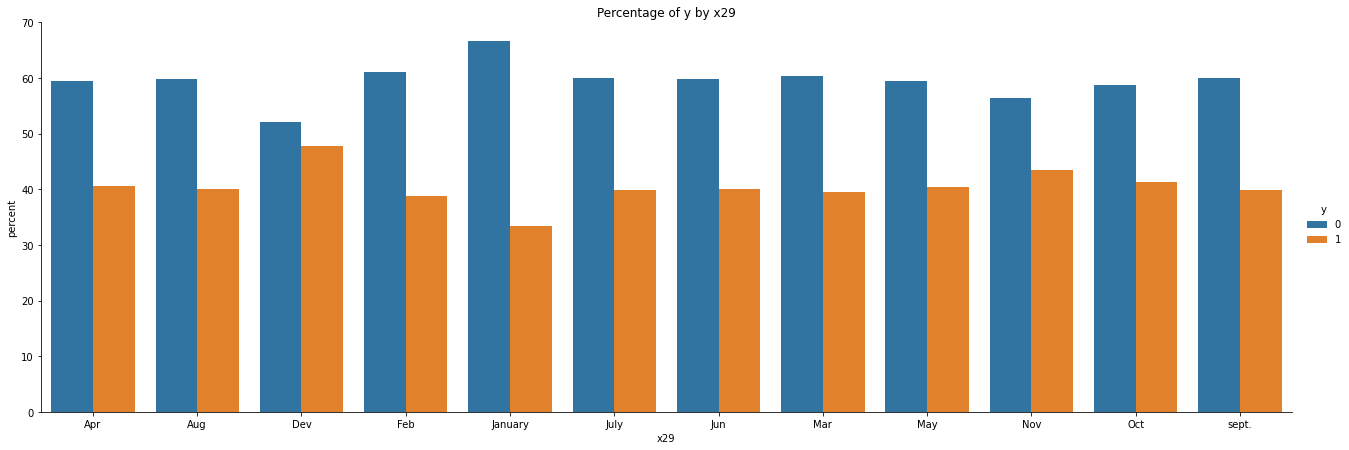

In [25]:
(df
.groupby('x29')['y']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='x29',y='percent',hue='y', kind='bar', height=6, aspect=3))
plt.title("Percentage of y by x29") ;

##### X30 vs Y

As can be seen, column `x30`, which appears to be day of the week, seems to have a roughly equal proportion of target variables on every day. This may mean this is a poor predictor of target variable.

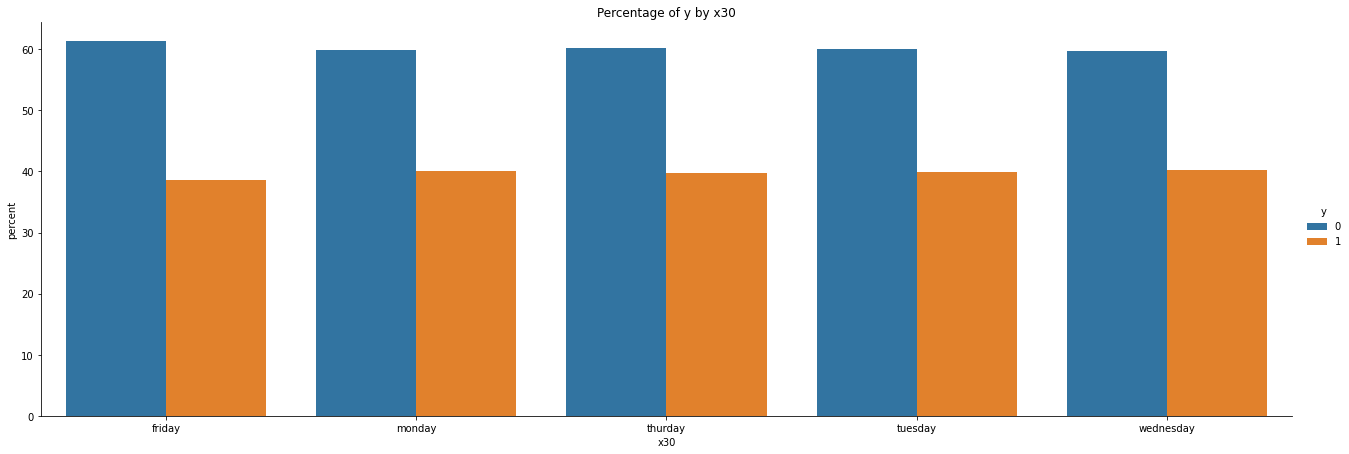

In [26]:
(df
.groupby('x30')['y']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='x30',y='percent',hue='y', kind='bar', height=6, aspect=3))
plt.title("Percentage of y by x30") ;

##### X32 vs Y

There are differences in propotion of the target variable across levels of variable `x32`. It might even be ordinal.

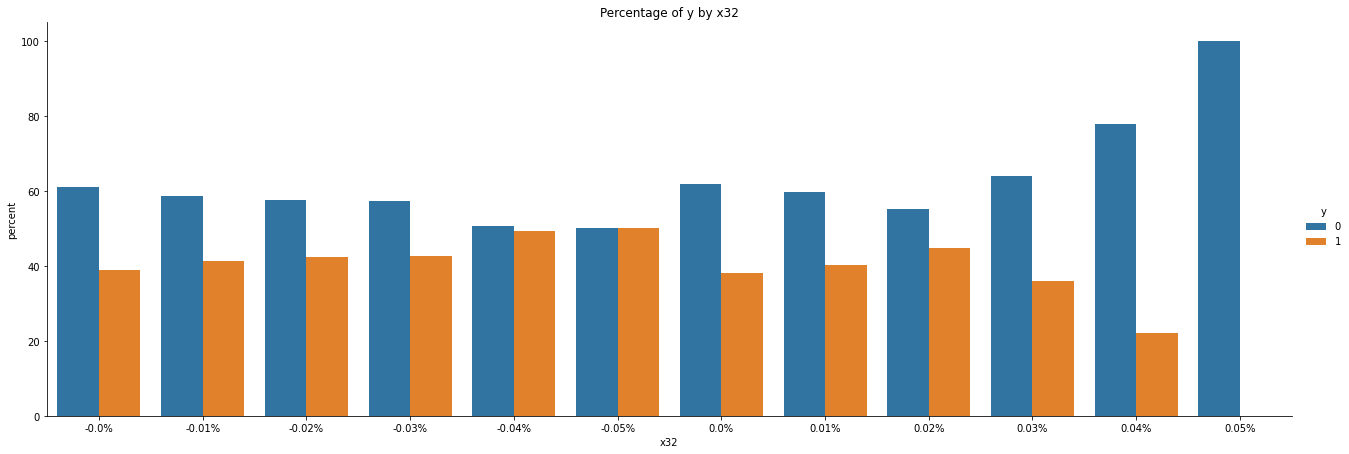

In [27]:
(df
.groupby('x32')['y']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='x32',y='percent',hue='y', kind='bar', height=6, aspect=3))
plt.title("Percentage of y by x32") ;

### Correlation Heatmap

As can be seen below, feature x2 and x6 as well as x38 and x41 have high positive correlation. And there are some features with high negative correlation. If model interpretability is required, removing these multi-collinear variables would be more important. However, in this case prediction accruaracy, precision, and recall are the goal in an effort to minimize monetary loss for the client. So we choose to leave all explanotory variables in our analysis.

Text(0.5, 1.0, 'Correlation heatmap of explanatory variables')

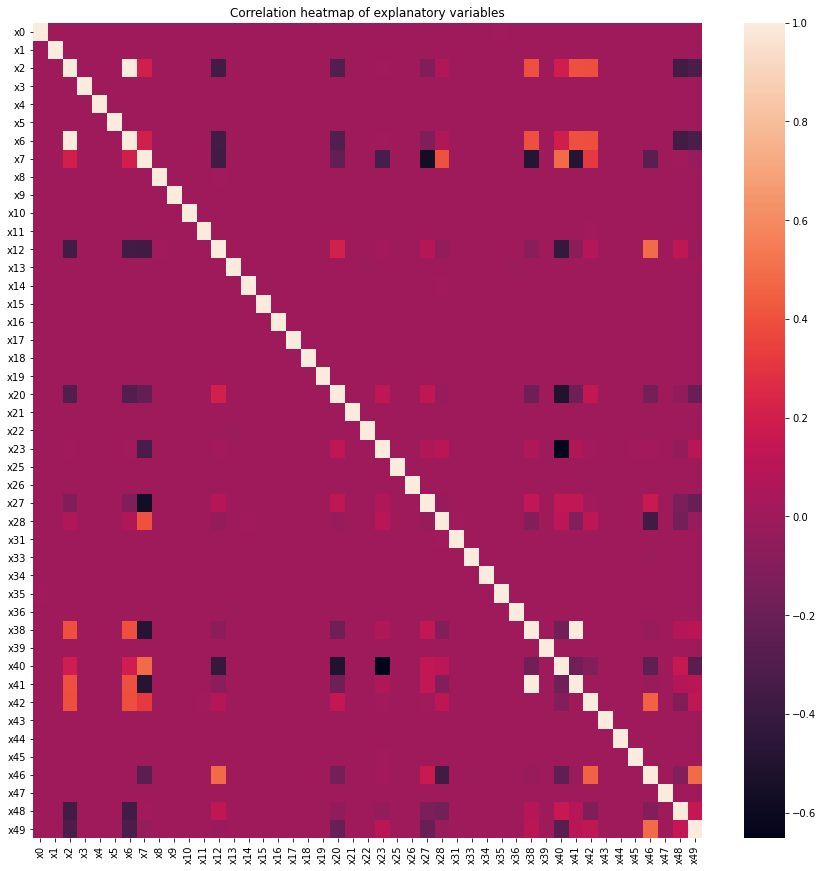

In [319]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15));
sns.heatmap(df.drop(columns=['y']).corr(), ax = ax);
ax.set_title("Correlation heatmap of explanatory variables")

## Model Preparation
### Proposed Methods
We propose comaring several different models capable of classifying the target variable as 0 or 1. Models compared include Logistic Regression, Random Forest Classification, XGBoost classification, SVM, and A deep neural network with 4 layers and 3 hidden layers, utilizing relu activation functions in the hidden layers an a sigmoid at the output layer.  We also compare an ensemble model which is combines random forest and neural network clasifiers with a soft voting method. We also compare these models to naive "all negative" and "all positive" models, which are used as a baseline. 

These methods are appropriate for the business objective of minimizing cost,  because they have a lot of predictive power. Although they do not favor explainability or interpretability, that is alright because we are given very little domain knowledge about the explanatory variables to begin with. In fact, our client compared the model needed to a "secret recipe" and prefers prediction power and minimizing cost over explainabilitiy. 


### Target Variable
Target is `'y'`. It can have a value of `0` or `1`. 


### Scaling
In order to compare feature importances and to ensure the best predictive power, standardized z-score centering and scaling is performed on all explanatory features. 


### Test/Train split
In order to evaluate the quality of this binary classification problem, we choose a randomized `80%/20%` train/test split where 80% of the data is used for training, and the remaining 20% data is held out to evaluate test accuracy. By keeping a holdout set, and being careful not to allow any of that holdout 'test' set to leak into our model, including feature engineering. As part of the model fitting for the neural network, we use `20%` of training set as validation set to do cross validation.

### Evaluation Method
Because our case study is a binary classification problem, predicting `0` or `1`, we can visualize the outcome of a binary classification model using a confusion matrix to generate metrics like accuracy, precision and recall. For the models in this study, we optimize for ROC AUC. This is done because the models need to be tunable by thresholding. 

Since the goal of this study is to minimize cost to the client, cost is calcualted for each model.  Thresholds are tweaked for the top performing models by performing a grid search to find the lowest cost per prediction is performed to find 

By multiplying these confusion matrices by the cost per prediction of: true positive \\$0, \\$0 for true negative, \\$100 for  false positive, false negative ($25) we can compare the direct cost of each model per prediction for a number of threholds. 

Ultimately, we choose not to optimize specifically for Recall or Precision, but instead for the cost outlined above. This is because the cost per false positive and cost per false negative act as weights on precision and recall. 

Models that predict a minimum number of false positives are most likely preferred due to the high cost associated with false postivies. 

### Assumptions
- Unseen data is assumed to have all features hydrated with values. That is to say, all incoming test data must not be missing. 
- The process by which new or incoming data was generated is the same as the process present in the data used in this study. 

# Preprocessing

In [29]:
df_encoded = one_hot_encode_data(df)
df_num = df[df.columns[df.dtypes == 'float64']]
df = pd.concat([df_num, df_encoded, df['y']], axis=1)

In [31]:
train, test = train_test_split(df, test_size=0.2)

In [32]:
train.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x25,x26,x27,x28,x31,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x24_america,x24_asia,x24_euorpe,x29_Apr,x29_Aug,x29_Dev,x29_Feb,x29_January,x29_July,x29_Jun,x29_Mar,x29_May,x29_Nov,x29_Oct,x29_sept.,x30_friday,x30_monday,x30_thurday,x30_tuesday,x30_wednesday,x32_-0.0%,x32_-0.01%,x32_-0.02%,x32_-0.03%,x32_-0.04%,x32_-0.05%,x32_0.0%,x32_0.01%,x32_0.02%,x32_0.03%,x32_0.04%,x32_0.05%,y
count,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.00000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.000000,126713.0,126713.000000
mean,-0.000172,0.000846,-1.118627,-0.014298,0.005965,0.005108,-1.626400,-7.654786,-0.029950,0.003199,0.007026,0.010344,-1.377047,-0.009937,0.019019,0.001073,0.006852,0.002464,0.012409,0.024595,0.299982,-0.014371,-0.011743,0.714463,-0.000436,-0.001671,-0.007186,0.014442,-0.005005,-0.009418,0.006714,-0.004554,0.003130,1.762556,6.059872,0.008622,-2.302325,6.701739,-1.827400,-0.004220,-0.004389,0.000801,-12.772835,0.025657,-0.003105,-0.685602,0.028111,0.868972,0.102918,0.042474,0.184196,0.000150,0.000876,0.000039,0.285054,0.257535,0.007663,0.136829,0.002202,0.015081,0.067901,0.003504,0.003133,0.18489,0.174789,0.633684,0.191851,0.212693,0.062211,0.010591,0.000781,0.000047,0.211549,0.254773,0.049719,0.005437,0.000347,0.0,0.401814
std,0.371615,6.358967,13.289983,8.062150,6.377098,7.670776,19.322637,30.503177,8.909794,6.356172,7.859858,8.770712,14.742772,8.945207,6.967373,3.270222,4.985155,7.584330,4.542106,7.596899,5.803094,9.412624,5.402118,14.918772,1.262645,0.842573,6.768488,14.433601,2.763916,1.745992,8.013920,2.379879,1.593050,1002.640111,16.917500,5.135471,17.048887,18.709417,5.103353,1.534498,4.171706,0.396339,36.630822,4.779887,1.931500,15.046720,0.165290,0.337433,0.303852,0.201669,0.387645,0.012244,0.029584,0.006282,0.451442,0.437278,0.087203,0.343668,0.046872,0.121877,0.251578,0.059091,0.055886,0.38821,0.379788,0.481799,0.393758,0.409214,0.241540,0.102366,0.027941,0.006881,0.408408,0.435735,0.217364,0.073539,0.018631,0.0,0.490267
min,-1.592635,-26.278302,-57.425570,-33.769091,-28.467536,-33.822988,-83.492464,-181.506976,-37.012061,-26.915956,-36.306571,-38.092869,-64.126068,-38.723514,-30.905214,-17.002359,-26.042983,-34.395898,-20.198686,-35.633396,-26.677396,-43.501854,-23.159072,-66.640341,-5.654531,-3.857484,-32.003555,-72.896705,-12.289364,-7.451454,-34.159104,-10.008149,-6.866024,-4734.540000,-74.297559,-22.101647,-74.059196,-82.167224,-27.933750,-6.380842,-17.983487,-1.753221,-201.826828,-20.437970,-8.490155,-65.791191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,-0.250834,-4.280911,-10.140895,-5.443412,-4.317646,-5.150915,-14.744099,-27.262723,-6.026230,-4.255020,-5.281452,-5.939457,-11.437522,-6.040

In [33]:
test.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x25,x26,x27,x28,x31,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x24_america,x24_asia,x24_euorpe,x29_Apr,x29_Aug,x29_Dev,x29_Feb,x29_January,x29_July,x29_Jun,x29_Mar,x29_May,x29_Nov,x29_Oct,x29_sept.,x30_friday,x30_monday,x30_thurday,x30_tuesday,x30_wednesday,x32_-0.0%,x32_-0.01%,x32_-0.02%,x32_-0.03%,x32_-0.04%,x32_-0.05%,x32_0.0%,x32_0.01%,x32_0.02%,x32_0.03%,x32_0.04%,x32_0.05%,y
count,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.00000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.0,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000
mean,-0.003351,0.015139,-1.267057,-0.057866,-0.025189,0.045978,-1.842205,-7.870239,-0.024466,0.008801,-0.024024,0.112085,-1.176927,0.068240,-0.031640,0.007889,0.006324,0.053177,0.020621,0.009482,0.294935,-0.079223,0.084034,0.773122,-0.006362,0.001620,0.010465,0.093026,-0.017709,0.002579,-0.033159,0.018459,0.018391,-4.536487,6.079274,-0.017157,-2.384446,6.723196,-1.855197,0.006008,-0.018717,0.001777,-12.668630,0.038681,0.013219,-0.617853,0.027021,0.867641,0.105338,0.041573,0.182297,0.000126,0.000884,0.000126,0.284163,0.260962,0.007892,0.137946,0.001641,0.014963,0.067426,0.003535,0.002746,0.181066,0.174942,0.63771,0.186685,0.215285,0.060892,0.011585,0.001168,0.0,0.213075,0.255185,0.050854,0.004924,0.000316,0.000032,0.398718
std,0.368845,6.265145,13.213125,8.084528,6.408118,7.677435,19.210890,30.694498,8.881164,6.347202,7.915302,8.755795,14.791809,8.982109,6.952604,3.276164,4.973794,7.514674,4.535439,7.586981,5.807499,9.404327,5.451839,14.867814,1.268717,0.845482,6.794594,14.453268,2.780514,1.755150,8.007115,2.376277,1.592036,987.701568,16.764504,5.128186,17.005597,18.540215,5.136912,1.538410,4.131902,0.397666,36.520210,4.820248,1.949348,14.978781,0.162147,0.338886,0.306993,0.199615,0.386096,0.011236,0.029717,0.011236,0.451022,0.439166,0.088485,0.344849,0.040482,0.121405,0.250763,0.059356,0.052334,0.385079,0.379924,0.48067,0.389665,0.411026,0.239136,0.107010,0.034156,0.0,0.409487,0.435972,0.219703,0.070002,0.017764,0.005618,0.489642
min,-1.581400,-26.053979,-59.394048,-33.864827,-26.724853,-27.999453,-86.354483,-149.800016,-37.691045,-27.980659,-33.213035,-34.087269,-64.197967,-36.205707,-28.685238,-13.497477,-18.464791,-31.219563,-18.578454,-30.555896,-22.735805,-41.262294,-23.644193,-62.095329,-6.364653,-3.590772,-27.262222,-61.031672,-10.472410,-6.878740,-36.116606,-9.875681,-6.541607,-3888.710000,-57.678773,-19.367188,-69.488115,-63.788161,-27.756708,-6.876234,-16.499248,-1.689034,-199.396118,-21.086333,-7.902376,-58.093762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.252984,-4.184491,-10.259563,-5.487580,-4.291370,-5.157788,-14.916634,-27.534396,-6.067958,-4.271295,-5.303299,-5.740787,-11.159829,-5.991031,-4.743786,-2.195668,-3.322187,-4.984848,-3.041127,-5.113642,-3.611727,-6.413288

In [34]:
X_train = train.drop(columns=['y'])
X_test = test.drop(columns=['y'])
y_train = train['y']
y_test = test['y']

In [35]:
t_slr = [('scale', StandardScaler(), df_num.columns)]
col_transform = ColumnTransformer(t_slr, remainder='passthrough')
col_transform.fit(X_train)
X_train_scaled_array = col_transform.transform(X_train)
X_test_scaled_array = col_transform.transform(X_test)
column_names = get_feature_names(col_transform)
X_train_scaled = pd.DataFrame(data=X_train_scaled_array, columns=column_names, index=X_train.index)
X_test_scaled = pd.DataFrame(data=X_test_scaled_array, columns=column_names, index=X_test.index)

Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available


# Model Building & Evaluation
Note: a training dataset was randomly split as 80% of the total scaled data. The remaining 20% of the data was held out as a test set. 

### Model 0 - Naive Prediction 

Below you can see a naive prediction model. This model predicts all negative values of the target variable `y`. The number of false negatives in this case equals the number of positive values because all of those values were predicted to be negative. The number of false positive is 0 because we make no positive prediction. The cost associated with the "all negative model" for the total amount of training data is `$1,270,175`. The cost associated with all negative for test data is `$318,475`. 

In [38]:
num_y1 = len(y_train[y_train == 1])
y_train_naive_cost = num_y1 * 25
print(f"all negative naive prediction cost = ${y_train_naive_cost}")

all negative naive prediction cost = $1272875


In [39]:
num_y1 = len(y_test[y_test == 1])
y_test_naive_cost = num_y1 * 25
print(f"all negative naive prediction cost = ${y_test_naive_cost}")

all negative naive prediction cost = $315775


Below you can see a naive prediction where the model predicts all positive values of the target variable `y`. The number of false negatives in this case equals 0 because we make no negative prediction. The number of false positive is the number of negative values. The cost associated with all positive predictions for the training data is `$7,590,600`. The cost associated with all positive for test data is `$1,894,000`

In [40]:
num_y0 = len(y_train[y_train == 0])
y_train_naive_cost = num_y0 * 100
print(f"all positive naive prediction cost = ${y_train_naive_cost}")

all positive naive prediction cost = $7579800


In [41]:
num_y0 = len(y_test[y_test == 0])
y_test_naive_cost = num_y0 * 100
print(f"all positive naive prediction cost = ${y_test_naive_cost}")

all positive naive prediction cost = $1904800


As you can see all negative naive prediction is preferable due to lower total cost.

### Model 1 - Logistic Regression

Next we tried a logisitic regression model via a grid search of parameters, scoring for 'roc_auc'. Although this model trains quickly, it does not perform particularly well compared to other models. With a cross validation based (out of fold) ROC AUC of only 0.7647515672162091

In [113]:
param_grid = [
    {'penalty': ['none', 'l2'], 'C': [0.001, 0.01, 0.1], 'class_weight': [ None], 'max_iter': [200], 'n_jobs': [-1]},
  ]

log = LogisticRegression(random_state=42)
log_reg = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc', 
                           return_train_score=True, n_jobs=-1)
log_search = log_reg.fit(X_train_scaled, y_train)

In [115]:
log_search.best_estimator_

LogisticRegression(C=0.01, max_iter=200, n_jobs=-1, random_state=42)

In [116]:
log_search.best_score_

0.7647515672162091

### Model 2 - RandomForest
Next we trained a Random Forest classifier model via a grid search of parameters for tuning, scoring for 'roc_auc'. Training time is still relatively fast, though not as fast as logistic regression. The best model had a validation (out of fold) ROC AUC of 0.9654849704726127. The best model splits on `entropy`, uses a max depth of 15, and 150 estimators This out of fold AUC is significantly better than the logistic regression. 

In [119]:
rf = RandomForestClassifier(random_state=0)
distributions = dict(criterion = ['gini', 'entropy'],
                    n_estimators = [100, 150],
                    max_depth = [10, 15],
                    class_weight = ['balanced'],
                    min_samples_split = [4, 6],
                    random_state=[0])

rf_clf = GridSearchCV(rf, distributions, scoring='roc_auc',n_jobs=-1, cv=5)
rf_search = rf_clf.fit(X_train_scaled, y_train)

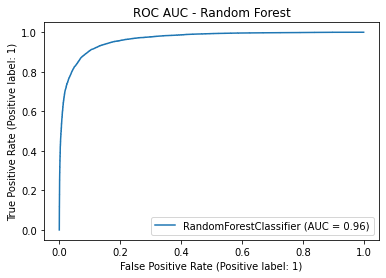

In [131]:
metrics.plot_roc_curve(rf_clf.best_estimator_, X_test_scaled, y_test);
plt.title("ROC AUC - Random Forest")
plt.show()

In [123]:
rf_search.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_split=4, n_estimators=150,
                       random_state=0)

In [124]:
rf_search.best_score_

0.9654849704726127

In [60]:
# subsampling 
train_scaled = X_train_scaled.copy()
train_scaled['y'] = y_train
train_scaled_subsampled = train_scaled.sample(10000)
X_subsampled_scaled = train_scaled_subsampled.drop(columns=['y'])
Y_subsampled = train_scaled_subsampled['y']

### Model 3 - XGBoost

In order to facilitate XGBoost (and other serial algorithms that are relatively slow) subsampling is employed to 10000 scaled records. We trained a XGBoost classifier model via a grid search of parameters for tuning, scoring for 'roc_auc'. Training time is slow, although subsampling helps with this. The best model had a validation (out of fold) ROC AUC of 0.9578638560800894. This out of fold AUC is again significantly better than the logistic regression. 

In [61]:
xgb_param = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample':[0.6, 0.8],
    'reg_alpha':[1e-5, 1],
    'random_state':[0]
}
# xgb_cv = GridSearchCV(estimator = xgb.XGBClassifier(objective= 'binary:logistic'), 
xgboost = GridSearchCV(xgb.XGBClassifier(objective= 'binary:logistic'), xgb_param, scoring='roc_auc',n_jobs=-1, cv=5)
xgb_search = xgboost.fit(X_subsampled_scaled,Y_subsampled)

[14:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [62]:
xgb_search.best_score_

0.9578638560800894

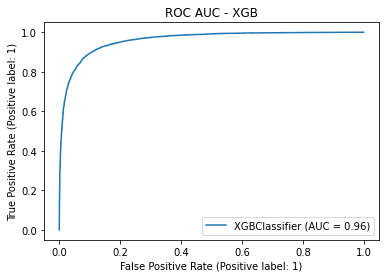

In [130]:
metrics.plot_roc_curve(xgb_search.best_estimator_, X_test_scaled, y_test);
plt.title("ROC AUC - XGB")
plt.show()

### Model 4 - SVM
In order to facilitate SVM (and other serial algorithms that are relatively slow) subsampling is employed to 10000 scaled records.
We trained a Support Vector model via a grid search of parameters for tuning, scoring for 'roc_auc'. Training time is slow again slow, although subsampling helps with this. The best model had a validation (out of fold) ROC AUC of 0.9236337711612983. This out of fold AUC is again significantly better than the logistic regression but slightly worse than XGB and Random Forest. 

In [64]:
# tuned rbf grid
param_grid = {'C': [10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'], #'poly', 'rbf', 'sigmoid'],
#               'epochs': [2,5,10],
              'probability': [True]
             }

svc = GridSearchCV(estimator = SVC(), param_grid = param_grid, scoring='roc_auc',n_jobs=-1, cv=5)
svc_rbf_search = svc.fit(X_subsampled_scaled, Y_subsampled)

In [65]:
svc_rbf_search.best_score_

0.9236337711612983

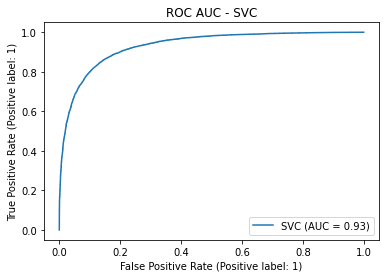

In [128]:
metrics.plot_roc_curve(svc_rbf_search.best_estimator_, X_test_scaled, y_test);
plt.title("ROC AUC - SVC")
plt.show()

### Model 5 - Neural Network
We compiled and trained a deep learning neural nework, scoring for 'roc_auc'. The neural network is composed of 4 layers, 3 of which are hidden with a relu activation function to avoid vanishing gradient. The final output layer uses a sigmoid to predict probabilities. Training time is surprisingly fast with a learning rate of .0001, an `Adam` solver, monitoring `validation loss`, with early stopping at a patience of 5 epochs. A Batch size of 20 with 500 epochs was used, but the training never gets past epoch 15 due to early stopping. The best model had a validation (out of fold) ROC AUC of 0.9966. and test AUC of 0.9843238367993307. This out of fold AUC is again significantly better than the logistic regression, in fact, it is the best of all models we have thus far compared.  Note: we used a keras classifier wrapper class here so that scikitlearn ensemble models can be used later. 

In [158]:
def build_nn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(len(X_subsampled_scaled.columns)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),    
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=[tf.keras.metrics.AUC()])
    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_nn_model, verbose=True)
history_nn = keras_clf.fit(X_train_scaled, y_train, epochs=500, validation_split=0.2, batch_size=20, callbacks=[callback], verbose=True)
keras_clf._estimator_type = "classifier"

Epoch 1/500
5069/5069 [==============================] - 9s 2ms/step - loss: 0.3481 - auc_7: 0.9240 - val_loss: 0.2689 - val_auc_7: 0.9559
Epoch 2/500
5069/5069 [==============================] - 8s 1ms/step - loss: 0.2329 - auc_7: 0.9659 - val_loss: 0.2218 - val_auc_7: 0.9703
Epoch 3/500
5069/5069 [==============================] - 8s 2ms/step - loss: 0.1910 - auc_7: 0.9767 - val_loss: 0.1904 - val_auc_7: 0.9769
Epoch 4/500
5069/5069 [==============================] - 8s 2ms/step - loss: 0.1648 - auc_7: 0.9823 - val_loss: 0.1734 - val_auc_7: 0.9805
Epoch 5/500
5069/5069 [==============================] - 8s 2ms/step - loss: 0.1469 - auc_7: 0.9856 - val_loss: 0.1626 - val_auc_7: 0.9828
Epoch 6/500
5069/5069 [==============================] - 8s 2ms/step - loss: 0.1338 - auc_7: 0.9878 - val_loss: 0.1636 - val_auc_7: 0.9832
Epoch 7/500
5069/5069 [==============================] - 8s 1ms/step - loss: 0.1235 - auc_7: 0.9893 - val_loss: 0.1529 - val_auc_7: 0.9846
Epoch 8/500
5069/5069 [====

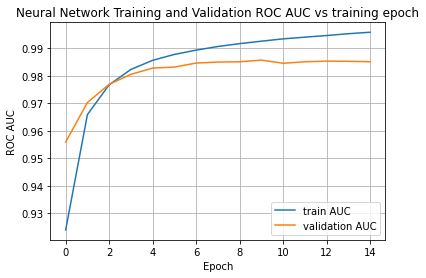

In [159]:
def plot_acc(model):
    plt.plot(model.history['auc_7'], label='train AUC')
    plt.plot(model.history['val_auc_7'], label='validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.title('Neural Network Training and Validation ROC AUC vs training epoch')
    plt.legend(loc='lower right')
    plt.grid(True)
    
plot_acc(history_nn)

Below we can see the divergence between train and validation ROC AUC. Early stopping stops training the model after 15 epochs, as you can see the validation AUC (out of fold) stops increasing. The train AUC continues climbing, but allowing the model to train further, only results in overfitting where the validation AUC drops significantly.  

In [160]:
y_predicted_prob_test_nn = nn_model2.predict(X_test_scaled)

990/990 [==============================] - 1s 740us/step


In [161]:
y_predicted_prob_test_nn
auc_score_nn =roc_auc_score(y_test,y_predicted_prob_test_nn)
print(f"Test ROC AUC for the Neural Network model was: {auc_score_nn}")

Test ROC AUC for the Neural Network model was: 0.9843238367993307


### Model 6 - Ensemble Model
Next we try an ensemble model with soft voting to combine random forest, and Neural network models. These models were chosen because they are relatively fast compared to the other models and they performed well individually. 
Note: subsampling of 100,000 records is used to decrease training time. A soft voting type is chosen to maximize the gain associated with any ensemble. 

In [172]:
# subsampling 
train_scaled = X_train_scaled.copy()
train_scaled['y'] = y_train
train_scaled_subsampled = train_scaled.sample(100000)
X_subsampled_scaled = train_scaled_subsampled.drop(columns=['y'])
Y_subsampled = train_scaled_subsampled['y']


ensemble_clf_soft = VotingClassifier(
             estimators=[('rf', rf_search.best_estimator_),
#                          ('xgb', xgb_search.best_estimator_),
#                          ('svm',svc_rbf_search), 
                         ('nn', keras_clf)], 
             voting='soft',
             flatten_transform=True)

ensemble_clf_soft.fit(X_subsampled_scaled, Y_subsampled)

3125/3125 [==============================] - 21s 5ms/step - loss: 0.3763 - auc_9: 0.9103


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=15,
                                                     min_samples_split=4,
                                                     n_estimators=150,
                                                     random_state=0)),
                             ('nn',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9b6397f8b0>)],
                 voting='soft')

990/990 [==============================] - 3s 3ms/step


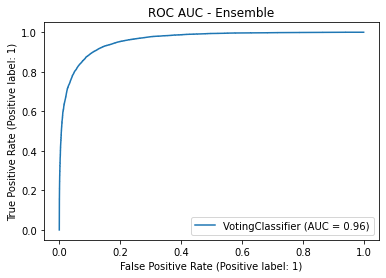

In [173]:
metrics.plot_roc_curve(ensemble_clf_soft, X_test_scaled, y_test);
plt.title("ROC AUC - Ensemble")
plt.show()

# Monetary Outcome 

In [207]:
# TODO: cleanup logs in this function
def get_test_cost_per_threshold(model, threshold_increment = .02):
    costs = []
    thresholds = []
    for threshold in np.arange(.3, .99, threshold_increment):
        y_prob = model.predict_proba(X_test_scaled)[:,1]
        y_hat_boolean = y_prob > threshold
        print(y_hat_boolean)
        # confusion_matrix sorts labels in ascending order e.g. [0,1]
        cm = confusion_matrix(y_true=y_test, y_pred=y_hat_boolean)
        false_negative_count = cm[1,0]
        false_positive_count = cm[0,1]
        print(f"false negative count was :{false_negative_count}, false positive count was :{false_positive_count}")
        false_negative_cost = false_negative_count*25
        false_positive_cost = false_positive_count*100
        total_cost = false_negative_cost + false_positive_cost
        total_cost_per_prediction = total_cost/len(y_test)
        print(f"cost per prediction was {total_cost_per_prediction}")
        costs.append(total_cost_per_prediction)
        thresholds.append(threshold)
    df = pd.DataFrame(data = costs, columns=['costs'])
    df['thresholds'] = thresholds
    return df


In [208]:
nn_cost_per_prediction = get_test_cost_per_threshold(keras_clf);

990/990 [==============================] - 5s 5ms/step
[False  True  True ...  True  True  True]
false negative count was :609, false positive count was :1161
cost per prediction was 4.145490703620695
990/990 [==============================] - 4s 4ms/step
[False  True  True ...  True  True  True]
false negative count was :635, false positive count was :1120
cost per prediction was 4.036585750812841
990/990 [==============================] - 4s 4ms/step
[False  True  True ...  True  True  True]
false negative count was :667, false positive count was :1068
cost per prediction was 3.897692477666593
990/990 [==============================] - 4s 4ms/step
[False  True  True ...  True  True  True]
false negative count was :691, false positive count was :1018
cost per prediction was 3.758799204520345
990/990 [==============================] - 4s 4ms/step
[False  True  True ...  True  True  True]
false negative count was :709, false positive count was :976
cost per prediction was 3.640424255816

NameError: name 'ensemble' is not defined

In [209]:
ensemble_cost_per_prediction = get_test_cost_per_threshold(ensemble_clf_soft);

990/990 [==============================] - 5s 5ms/step
[ True  True  True ...  True  True  True]
false negative count was :532, false positive count was :4090
cost per prediction was 13.33059755674106
990/990 [==============================] - 5s 5ms/step
[ True  True  True ...  True  True  True]
false negative count was :623, false positive count was :3684
cost per prediction was 12.120805580984248
990/990 [==============================] - 5s 5ms/step
[ True  True  True ...  True  True  True]
false negative count was :728, false positive count was :3359
cost per prediction was 11.17775182297421
990/990 [==============================] - 5s 5ms/step
[ True  True  True ...  True  True  True]
false negative count was :817, false positive count was :3061
cost per prediction was 10.307301366836075
990/990 [==============================] - 5s 5ms/step
[ True  True  True ...  True  True  True]
false negative count was :918, false positive count was :2758
cost per prediction was 9.430537580

In [212]:
rf_cost_per_prediction = get_test_cost_per_threshold(rf_search.best_estimator_);

[ True  True  True ...  True  True  True]
false negative count was :276, false positive count was :5917
cost per prediction was 18.895798478487325
[ True  True  True ...  True  True  True]
false negative count was :337, false positive count was :5246
cost per prediction was 16.82581520881341
[ True  True  True ...  True  True  True]
false negative count was :399, false positive count was :4623
cost per prediction was 14.90814103980555
[ True  True  True ...  True  True  True]
false negative count was :483, false positive count was :4063
cost per prediction was 13.206698443764008
[ True  True  True ...  True  True  True]
false negative count was :583, false positive count was :3509
cost per prediction was 11.53682250071025
[ True  True  True ...  True  True  True]
false negative count was :704, false positive count was :3057
cost per prediction was 10.205498910950473
[ True  True  True ...  True  True  True]
false negative count was :816, false positive count was :2675
cost per predicti

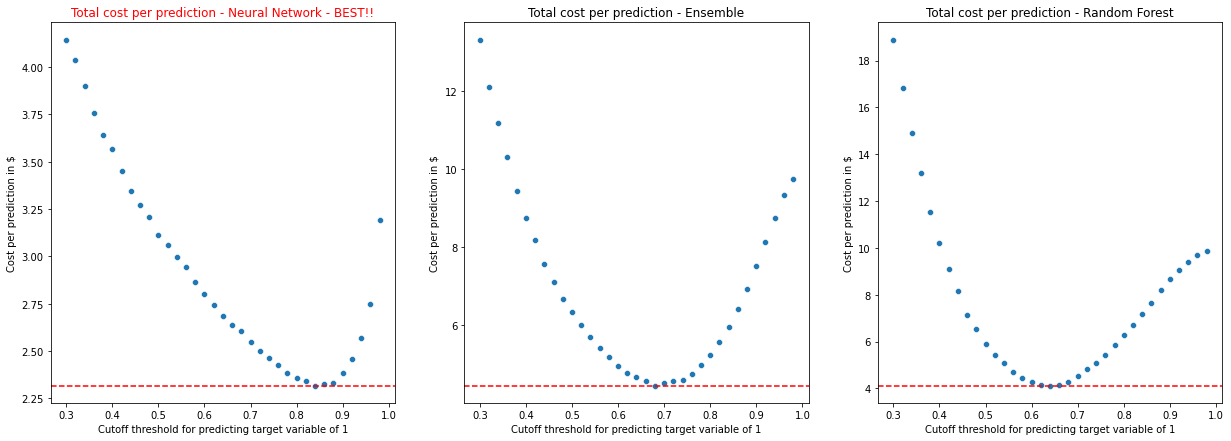

In [238]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7));
ax = ax=axes[0];
sns.scatterplot(data=nn_cost_per_prediction, x="thresholds", y="costs", ax=ax);
ax.set_title("Total cost per prediction - Neural Network - BEST!!", c='red');
ax.set_xlabel("Cutoff threshold for predicting target variable of 1");
ax.set_ylabel("Cost per prediction in $");
ax.axhline(nn_cost_per_prediction['costs'].min(), ls='--', c='red');

ax = ax=axes[1]
sns.scatterplot(data=ensemble_cost_per_prediction, x="thresholds", y="costs", ax=ax);
ax.set_title("Total cost per prediction - Ensemble");
ax.axhline(ensemble_cost_per_prediction['costs'].min(), ls='--', c='red');
ax.set_xlabel("Cutoff threshold for predicting target variable of 1");
ax.set_ylabel("Cost per prediction in $");

ax = ax=axes[2]
sns.scatterplot(data=rf_cost_per_prediction, x="thresholds", y="costs", ax=ax);
ax.set_title("Total cost per prediction - Random Forest");
ax.axhline(rf_cost_per_prediction['costs'].min(), ls='--', c='red');
ax.set_xlabel("Cutoff threshold for predicting target variable of 1");
ax.set_ylabel("Cost per prediction in $");



### Cost Per Prediction (Top Models)
Of the Naive models, the "all negative" model incurs less cost than the "all positive" model. When we calculate the cost per prediction for the all negative model, it is \\$60.128160611130404 per prediction. This is MUCH higher than the lowest cost per prediction for the Deep Neural Network model, Random Forest Classifier, and the Ensemble model. 

Below you can see the lowest cost for each model after grid searching prediction cutoff thresholds. A Grid search for these prediction cutoffs can be seen in the plot above, where average cost per prediction is compared for each model, relative to that model's cutoff threshold used to predict the positive case of y=1. The way this was achieved was training for ROC AUC, and grid searching on each threshold, calculating the total cost for each prediction. s

The lowest cost per prediction is for the neural network model at \\$2.316992329303324 per prediction. The Random Forest model is the next best at \\$4.124183212853941 per prediction and the ensemble model is next at $4.444584740679946 per prediction. These values were calculated using test data. 


In [254]:
cost_per_prediction_all_negative_naive = y_test_naive_cost/len(y_test)
print(f"cost per prediction of all negative naive cost is: ${cost_per_prediction_all_negative_naive}")
print(f"cost per prediction for the deep neural network model is: ${nn_cost_per_prediction['costs'].min()}")
print(f"cost per prediction for the ensemble model is: ${ensemble_cost_per_prediction['costs'].min()}")
print(f"cost per prediction for the random Forest model is is: ${rf_cost_per_prediction['costs'].min()}")

cost per prediction of all negative naive cost is: $60.128160611130404
cost per prediction for the deep neural network model is: $2.316992329303324
cost per prediction for the ensemble model is: $4.444584740679946
cost per prediction for the random Forest model is is: $4.124183212853941


### Neural Network 
**Confusion Matrix**
Note, when y=1 is considered a "positive" prediction.

After finding the best cutoff threshold in terms of cost per prediction of the above Neural Network model to be \\$2.316992329303324 per prediction, 
We can see in the confusion and cost matrices below that the neural network based model predicts False Negatives 2.79049\% of the time. It predicts False Positives, 2.41485\% of the time and lastly, 
True negatives are predicted 57.7133\% of the time where True positives 37.0813\% of the time. 

As can be seen in the cost matrix further below, for the neural network based model and sfor every 1000 records, the company looses \\$2414.85 to false positive predictions, and \\$697.6 to false negative predictions. As expected, true positive and true negative predictions cost the company \\$0.00 per 1000 records. 


In [312]:
# calculate the threshold assoiated with the minimum cost per prediction for NN
idx_for_minimum_nn_cost = nn_cost_per_prediction['costs'].idxmin()
nn_cost_per_prediction_for_min_nn_cost = nn_cost_per_prediction.loc[idx_for_minimum_nn_cost]
nn_threshold_min_cost = nn_cost_per_prediction_for_min_nn_cost['thresholds']
nn_threshold_min_cost

0.8400000000000005

990/990 [==============================] - 4s 4ms/step


Text(0.5, 1.0, 'Neural Network Test Confusion Matrix - Percentage')

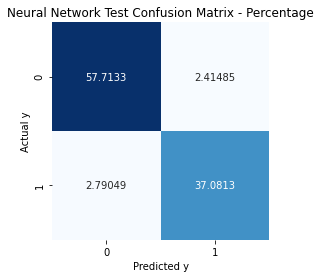

In [305]:
y_predicted_nn = keras_clf.predict(X_test_scaled) > nn_threshold_min_cost
mat_nn = confusion_matrix(y_test, y_predicted_nn)
mat_nn = mat_nn * 100/ len(y_test)
labels = ['0', '1']

 
sns.heatmap(mat_nn, square=True, annot=True, cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, fmt='g')
 
plt.xlabel('Predicted y')
plt.ylabel('Actual y')
plt.title("Neural Network Test Confusion Matrix - Percentage")

990/990 [==============================] - 4s 4ms/step


Text(0.5, 1.0, 'Neural Network Test Confusion Matrix - Cost Per 1000 Records in $')

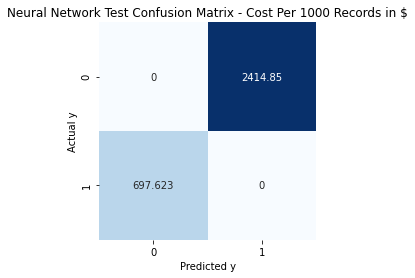

In [314]:
y_predicted_nn = keras_clf.predict(X_test_scaled) > nn_threshold_min_cost
cm_nn = confusion_matrix(y_test, y_predicted_nn)
mat_nn = confusion_matrix(y_test, y_predicted_nn) * [[0, 100], [25, 0]]
mat_nn = mat_nn * 1000/ len(y_test)
labels = ['0', '1']
 
sns.heatmap(mat_nn, square=True, annot=True, cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, fmt='g')
 
plt.xlabel('Predicted y')
plt.ylabel('Actual y')
plt.title("Neural Network Test Confusion Matrix - Cost Per 1000 Records in $")

### Random Forest
**Confusion Matrix**
Note, when y=1 is considered a "positive" prediction.

After finding the best cutoff threshold in terms of cost per prediction of the above Random Forest model to be \\$4.124183212853941 per prediction, 
We can see in the confusion and cost matrices below that the random forest based model predicts False Negatives 4.77288\% of the time. It predicts False Positives, 4.69712\% of the time and lastly, 
True negatives are predicted 55.431\% of the time where True positives 35.099\% of the time. 

As can be seen in the cost matrix further below, for the random forest model and for every 1000 records, the company looses \\$4697.12 to false positive predictions, and \\$1193.22 to false negative predictions. As expected, true positive and true negative predictions cost the company \\$0.00 per 1000 records. 

In [281]:
# calculate the threshold assoiated with the minimum cost per prediction for the Random Forest model 
idx_for_minimum_rf_cost = rf_cost_per_prediction['costs'].idxmin()
rf_cost_per_prediction_for_min_rf_cost = rf_cost_per_prediction.loc[idx_for_minimum_rf_cost]
rf_threshold_min_cost = rf_cost_per_prediction_for_min_rf_cost['thresholds']
rf_threshold_min_cost

0.6400000000000003

Text(0.5, 1.0, 'Random Forest Test Confusion Matrix - Percentage')

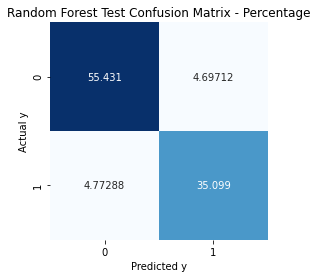

In [307]:
y_predicted_rf = rf_search.best_estimator_.predict(X_test_scaled) > rf_threshold_min_cost
mat_rf = confusion_matrix(y_test, y_predicted_rf)
mat_rf = mat_rf * 100/ len(y_test)
labels = ['0', '1']

 
sns.heatmap(mat_rf, square=True, annot=True, cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, fmt='g')
 
plt.xlabel('Predicted y')
plt.ylabel('Actual y')
plt.title("Random Forest Test Confusion Matrix - Percentage")

Text(0.5, 1.0, 'Random Forest Test Cost Matrix - Per 1000 Records in $')

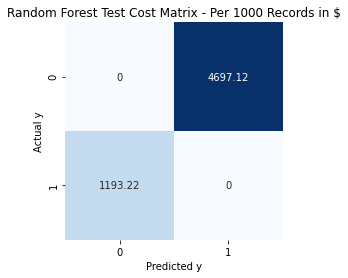

In [313]:
y_predicted_rf = rf_search.best_estimator_.predict(X_test_scaled) > rf_threshold_min_cost
mat_rf = confusion_matrix(y_test, y_predicted_rf)* [[0, 100], [25, 0]]
mat_rf = mat_rf *1000/ len(y_test)
labels = ['0', '1']

 
sns.heatmap(mat_rf, square=True, annot=True, cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, fmt='g')
 
plt.xlabel('Predicted y')
plt.ylabel('Actual y')
plt.title("Random Forest Test Cost Matrix - Per 1000 Records in $")

### Ensemble 
**Confusion Matrix**
Note, when y=1 is considered a "positive" prediction.

After finding the best cutoff threshold in terms of cost per prediction of the above Ensemble model to be \\$4.444584740679946 per prediction, 
We can see in the confusion and cost matrices below that the ensemble based model predicts False Negatives 4.96859\% of the time. It predicts False Positives, 5.41684\% of the time and lastly, 
True negatives are predicted 55.431\% of the time where True positives 35.099\% of the time. 

As can be seen in the cost matrix further below, for the ensemble model and for every 1000 records, the company looses \\$4968.59 to false positive predictions, and \\$1354.21 to false negative predictions. As expected, true positive and true negative predictions cost the company \\$0.00 per 1000 records. 

In [290]:
# calculate the threshold assoiated with the minimum cost per prediction for the Ensemble model 
idx_for_minimum_ensemble_cost = ensemble_cost_per_prediction['costs'].idxmin()
ensemble_cost_per_prediction_for_min_ensemble_cost = ensemble_cost_per_prediction.loc[idx_for_minimum_ensemble_cost]
ensemble_threshold_min_cost = ensemble_cost_per_prediction_for_min_ensemble_cost['thresholds']
ensemble_threshold_min_cost

0.6800000000000004

990/990 [==============================] - 4s 4ms/step


Text(0.5, 1.0, 'Ensemble Test Confusion Matrix - Percentage')

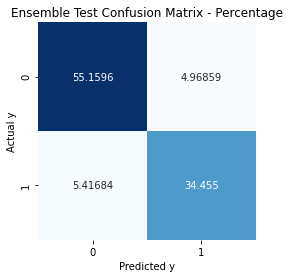

In [311]:
y_predicted_ensm = ensemble_clf_soft.predict(X_test_scaled) > ensemble_threshold_min_cost
mat_ens = confusion_matrix(y_test, y_predicted_ensm)
mat_ens = mat_ens * 100/len(y_test)
labels = ['0', '1']

 
sns.heatmap(mat_ens, square=True, annot=True, cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, fmt='g')
 
plt.xlabel('Predicted y')
plt.ylabel('Actual y')
plt.title("Ensemble Test Confusion Matrix - Percentage")

990/990 [==============================] - 4s 4ms/step


Text(0.5, 1.0, 'Ensemble Test Cost Matrix - Per 1000 Patients in $')

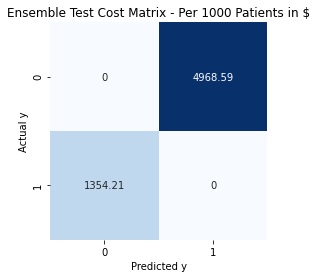

In [302]:
y_predicted_ensm = ensemble_clf_soft.predict(X_test_scaled) > 0.5
mat_ens = confusion_matrix(y_test, y_predicted_ensm) * [[0, 100], [25, 0]]
mat_ens = mat_ens *1000 / len(y_test)
labels = ['0', '1']

 
sns.heatmap(mat_ens, square=True, annot=True, cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels, fmt='g')
 
plt.xlabel('Predicted y')
plt.ylabel('Actual y')
plt.title("Ensemble Test Cost Matrix - Per 1000 Records in $")

It is the recommendation of this research that, if explainability is not needed for predicting the target variable y=1 and y=0, then the neural network based model highlighted above is the best. This is because it's average cost per prediction is the lowest at \\$2.316992329303324 per prediction. The neural network model beat out ensemble models, random forest, and a naive "all negatives" prediction. 

# Case Conclusions

The primary goal in this study is to generate and compare models capable of classifying 0 and 1 for a target variable while minimizing monetary loss for a client. As such, we compared  models capable of predicting class 1 or class 0 for the target variable. The financial penalty for incrorrectly predicting 1 is \\$100.00 per prediction, and the financial penalty for incorrectly predicting class 0 is \\$25.00 per prediction.

Models were trained to perform well with a technique called thresholding which is meant to optimize the monetary cost for each model's predictions. Models were evaulated based on the lowest average cost per prediction. After comparing Random Forests, XGBoost models, Deep Neural Networks, Support Vector Machine Models, Ensembles, and logistic regression to one another and to a naive model which predicts only negative values for the target variable, the deep Neural network model performed best. It had the overall lowest cost to the client of \\$2.316992329303324 per prediction. 

Although the deep neural network models are not highly explainable in terms of local model interpretability, the goal of this study was not interpretability but rather minimizing cost. As such, the Neural Network is considered the best model. 